# **ECE 239AS: Problem Set #1**

This problem set will revisit the imaging pipeline, denoising, and HDR imaging from the corresponding lectures and textbook sections. The goal is to develop a working understanding of the digital image formation model that is central to most modern day imaging devices. This will be important in later course material when we discuss extreme imaging systems that. With that goal in mind, the organization of this notebook is split into three problems:

1.   Imaging Pipeline
2.   Denoising
3.   High Dynamic Range Imaging

These three steps are a key part of the digital photography pipeline.

## How to Implement

Sections of code you need to write are marked with:

** STUDENT CODE HERE ** and have function names beginning with "student_". After the key student functions, we will include a call to a function named "check_code_correctness" which will evaluate your output against an output from the TAs.

NOTE: This will only check for correctness if you use the exact algorithm we do. We **highly encourage** you to explore new algorithms not covered in class, but these cannot be sanity checked by our code.

In [ ]:
!pip install rawpy
!pip install imageio
!pip install gdown

In [ ]:
# Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import rawpy
import json
import scipy
import imageio.v3 as iio
%matplotlib inline

In [ ]:
def check_code_correctness(test_function, test_in, test_out):
    """Checks if the given function behaves as expected

    Args:
      test_function: Function to test
      test_in: The sample input to test on
      test_out: The expected output of the function given the specified input

    Returns:
      True if the function behaves as expected, False otherwise (wrong answer or error)
    """


    try:
      student_out = test_function(test_in)
    except NotImplementedError as err:
      print("Please implement and remove \'raise NotImplementedError\' ")
      return False
    except RuntimeError as err:
      print("Please make sure you have the right dimensions and type")
      return False
    except:
      print("An exception occurred: could not compute output")
      return False

    try:
        if not( np.allclose( student_out, test_out) ):
            print("Test failed, student output does not match test output")
            print(test_out)
            return False
    except TypeError as err:
        print("Please make sure your function outputs the correct type")
        return False
    except:
        print("An exception occurred: could not check output")
        return False

    return True

In [ ]:
# Get relevant data -- see references below for sources
!wget http://storage.googleapis.com/gresearch/refraw360/raw.zip
!unzip raw.zip

!wget https://www.pauldebevec.com/Research/HDR/SourceImages/Memorial_SourceImages.zip
!mkdir hdr
!unzip Memorial_SourceImages.zip -d hdr

!gdown https://drive.google.com/uc?id=1bGFlFUdeVThzXSLQn0J3PVUxtpt4tRua
!unzip sol.zip

--2023-10-20 11:10:04--  http://storage.googleapis.com/gresearch/refraw360/raw.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.207, 142.251.6.207, 172.217.214.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20483316803 (19G) [application/zip]
Saving to: ‘raw.zip.1’

raw.zip.1             6%[>                   ]   1.33G  88.6MB/s    eta 3m 46s ^C
Archive:  raw.zip
replace rawnerf/scenes/bikes/raw/IMG_3384.dng? [y]es, [n]o, [A]ll, [N]one, [r]ename: --2023-10-20 11:10:23--  https://www.pauldebevec.com/Research/HDR/SourceImages/Memorial_SourceImages.zip
Resolving www.pauldebevec.com (www.pauldebevec.com)... 173.254.30.120
Connecting to www.pauldebevec.com (www.pauldebevec.com)|173.254.30.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9227471 (8.8M) [application/zip]
Saving to: ‘Memorial_SourceImages.zip.1’

Memorial_Sou

## Problem 1: Imaging Pipeline

Textbook Section: 2.2.4

In this problem, we will re-create part of the imaging pipeline, specifically demosaicking, white balancing, color transforms, and gamma encoding. By the end, you will be able to take in RAW images and output processed images. For each of the steps, we will suggest an implementation technique based on what was covered in Lecture 2.

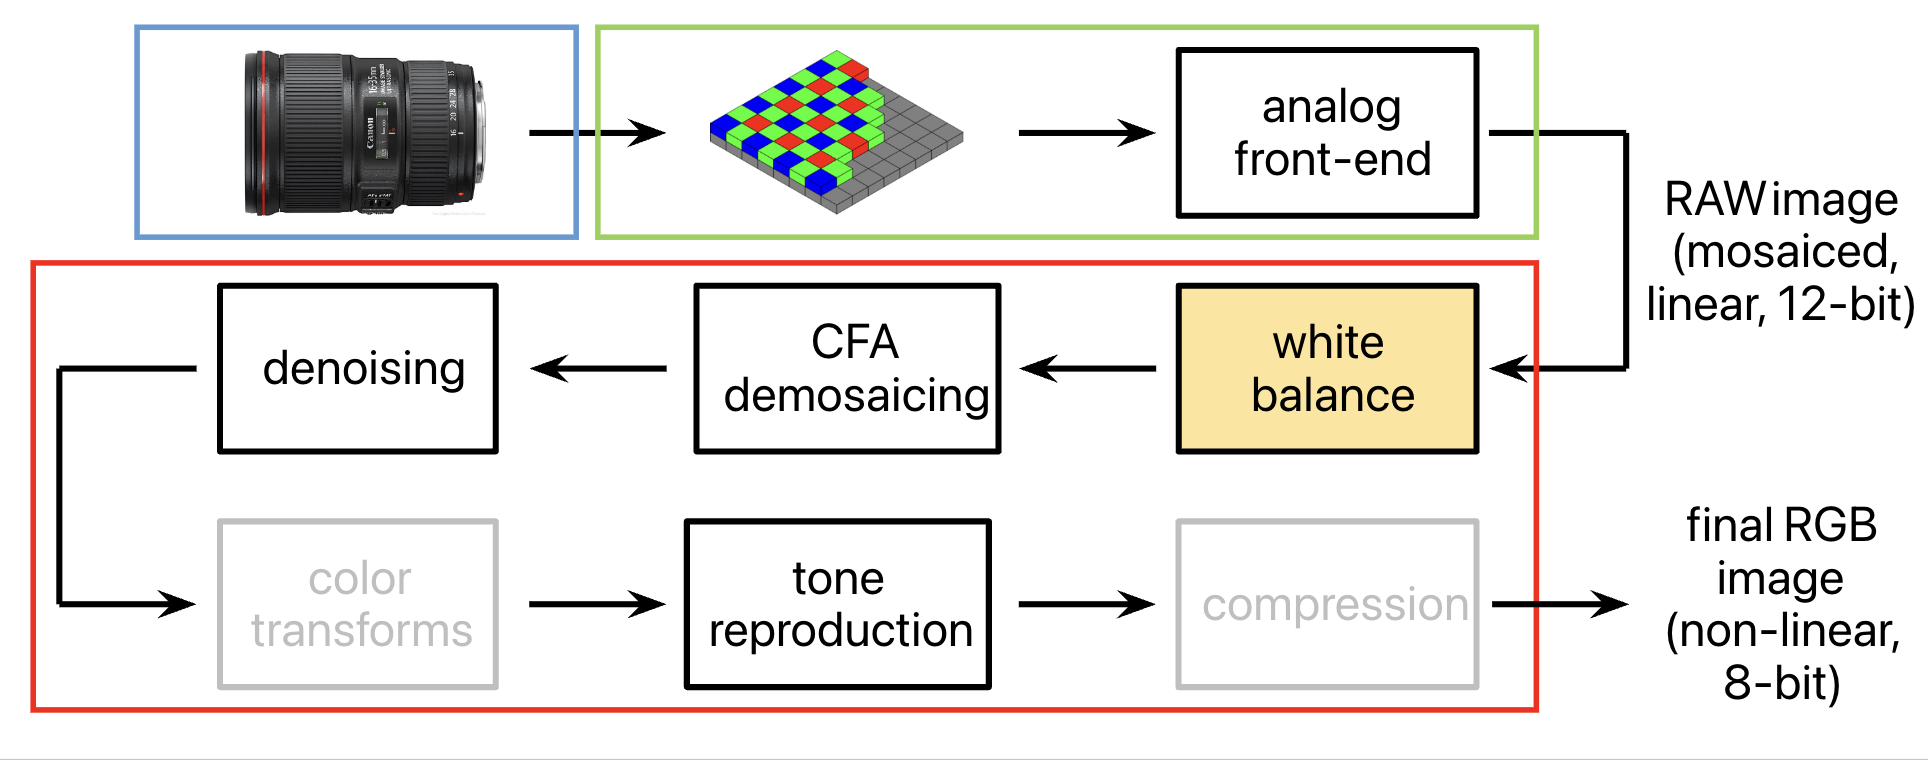

We load one specific image at first for code correctness checks, but feel free to try new images from the dataset or images you capture yourself!

In [ ]:
dng_file = "/content/rawnerf/scenes/windowlegovary/raw/IMG_6796.dng"
meta_file = "/content/rawnerf/scenes/windowlegovary/raw/IMG_6796.json"

dng = rawpy.imread(dng_file)
with open(meta_file, "r") as json_file:
    meta = json.load(json_file)
raw_img = dng.raw_image # raw is now a numpy array

# Convert to between 0-1
blacklevel = np.array(meta[0]['BlackLevel']).reshape(1, 1)
whitelevel = np.array(meta[0]['WhiteLevel']).reshape(1, 1)
raw_img = (raw_img - blacklevel) / (whitelevel - blacklevel)

Let's visualize the input (RAW images) and expected output (Processed images):

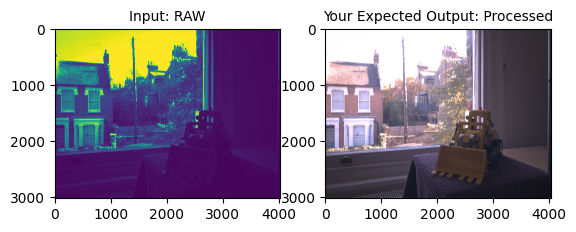

Lets start with the first step: demoisaicking. The function should take in a mosaicked image in the bayer pattern and return a RGB image. We discussed one way to do this in class: bilinear interpolation. This technique gets values for a pixel by averaging the values of its neighbors. However, the positions of a pixels neighbors are not the same for different channels. We've put the 2x2 pattern (RGGB in this case) for the raw image below. Let's start by visualizing the expected output:

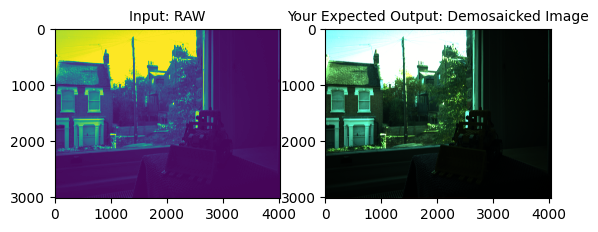

In [ ]:
def student_demosaicking(mosaicked_image):
    """Converts Bayer data into a full RGB image.

    Input data should be ndarray of shape [height, width] with 2x2 mosaic pattern:
        -------------
        |red  |green|
        -------------
        |green|blue |
        -------------

    Args:
        bayer_img: [H, W] numpy array. Contains values in the bayer pattern

    Returns:
        rgb_img: [H,W,3] numpy array.


    Potential Implementation:

    [Lecture 2] A potential implementation is bilinear interpolation
    where each pixel value is averaged from its four neighbors. Where those neighbors
    are located will vary based on the color you are trying to interpolate. Our code will
    sanity check bilinear interpolation.
    """
    h, w = mosaicked_image.shape

    x = np.arange(w)
    y = np.arange(h)

    r_x = 1 - x%2
    r_y = 1 - y%2
    r_xx, r_yy = np.meshgrid(r_x,r_y)
    r = np.multiply(r_xx, r_yy)

    b_x = x%2
    b_y = y%2
    b_xx, b_yy = np.meshgrid(b_x,b_y)
    b = np.multiply(b_xx, b_yy)

    g_x = x%2
    g_y = y%2
    g_xx, g_yy = np.meshgrid(g_x,g_y)
    g = np.where(g_xx + g_yy==2, 0, g_xx + g_yy)

    r_pattern = np.multiply(r, mosaicked_image)
    g_pattern = np.multiply(g, mosaicked_image)
    b_pattern = np.multiply(b, mosaicked_image)

    # kernel shape can be tricky, it's like averaging over neighboring values based on spatial distance
    # e.g R pattern: if land on B, avg over 4 corners; if land on R take central R value; if land on G, avg over top and bottom
    RGB = np.zeros([h, w, 3])
    rb_kernel = np.array([[0.25,0.5,0.25],[0.5,1.0,0.5],[0.25,0.5,0.25]])
    g_kernel = np.array([[0,0.25,0],[0.25,1.0,0.25],[0,0.25,0]])

    RGB[:,:,0] = scipy.ndimage.convolve(r_pattern, rb_kernel, mode='wrap')
    RGB[:,:,1] = scipy.ndimage.convolve(g_pattern, g_kernel, mode='wrap')
    RGB[:,:,2] = scipy.ndimage.convolve(b_pattern, rb_kernel, mode='wrap')

    return RGB

In [ ]:
check_code_correctness(student_demosaicking, raw_img, np.load('/content/sol/demosaick.npy'))

True

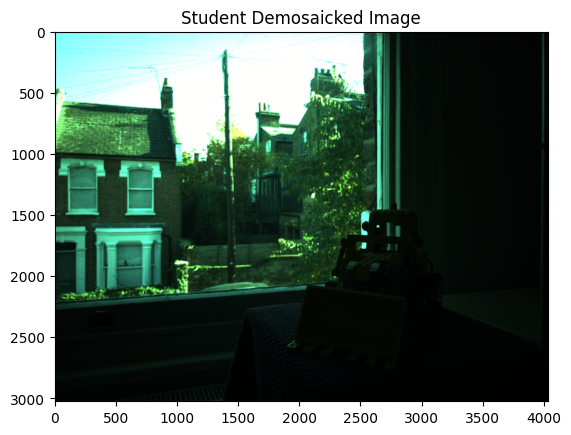

In [ ]:
demosaicked_img = student_demosaicking(raw_img)
demosaicked_img = np.where(demosaicked_img>1.0, 1.0, demosaicked_img)
plt.imshow(demosaicked_img)
plt.title("Student Demosaicked Image")
plt.show()

The next step is white balancing. A simple implementation is the gray-world assumption. This is what we will sanity check with the code correctness function. Once again, lets start by visualizing the expected output:

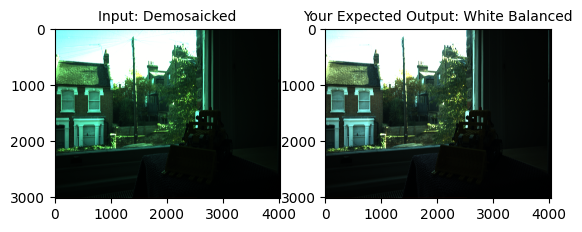

In [ ]:
def student_white_balancing(demosaicked_image):
    """White balances an image.

    Args:
        demoisaicked_image: [H,W,3] numpy array containing RGB values

    Returns:

        white_balanced_img: [H,W,3] numpy array

    Potential Implementation:

    [Lecture 2] Two common implementations are the gray-world assumption or the
    white-world assumption. Both can be implemented using a matrix multiplication.
    Our code will sanity check the gray-world assumption.
    """

    #Gray World Assumption
    R_avg = np.mean(demosaicked_image[:,:,0])
    G_avg = np.mean(demosaicked_image[:,:,1])
    B_avg = np.mean(demosaicked_image[:,:,2])

    R_wbal = np.multiply(G_avg/R_avg, demosaicked_image[:,:,0])
    G_wbal = demosaicked_image[:,:,1]
    B_wbal = np.multiply(G_avg/B_avg, demosaicked_image[:,:,2])

    """
    R_max = np.max(demosaicked_image[:,:,0])
    G_max = np.max(demosaicked_image[:,:,1])
    B_max = np.max(demosaicked_image[:,:,2])

    R_wbal = np.multiply(G_max/R_max, demosaicked_image[:,:,0])
    G_wbal = demosaicked_image[:,:,1]
    B_wbal = np.multiply(G_max/B_max, demosaicked_image[:,:,2])
    """
    return np.stack([R_wbal, G_wbal, B_wbal], axis=-1)

In [ ]:
check_code_correctness(student_white_balancing, demosaicked_img, np.load('/content/sol/white_balance.npy'))

True

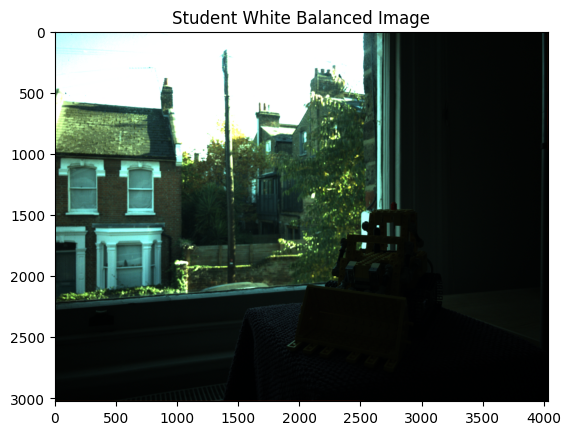

In [ ]:
white_balanced_img = student_white_balancing(demosaicked_img)
plt.imshow(white_balanced_img)
plt.title("Student White Balanced Image")
plt.show()

Next, we have to convert to RGB space. We will provide the individual matrices to convert between spaces, but you will have to choose how to apply them. Let's start by visualizing the expected output image.

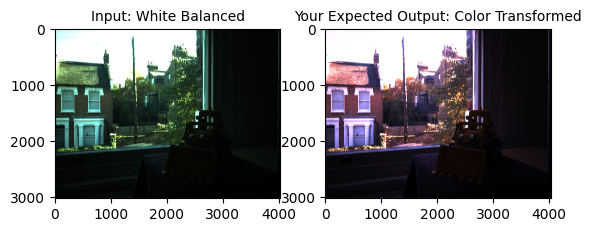

In [ ]:
xyz2cam = np.array([float(x) for x in meta[0]["ColorMatrix2"].split(" ")]).reshape(3,3) # load from the picture metadata

# Color conversion from reference illuminant XYZ to RGB color space.
# See http://www.brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html.
rgb2xyz = np.array([[0.4887180, 0.3106803, 0.2006017],
                    [0.1762044, 0.8129847, 0.0108109],
                    [0.0000000, 0.0102048, 0.9897952]])

We've given you two matrices here: one converts from xyz color space to camera color space. The other converts from RGB color space to xyz color space. How can we combine these into a matrix that converts from camera space to RGB space?

In [ ]:
def student_color_transform(white_balanced_image):
    """Color transform from camera space to rgb

    Args:
        white_balanced_image: [H,W,3] numpy array in camera color space

    Returns:

        rgb_image: [H,W,3] numpy array in RGB color space

    Potential Implementation:

    How would you combine the provided matrices to get the image into RGB space?
    """
    H, W, _ = white_balanced_image.shape
    pixel_rgb = white_balanced_image.reshape([H*W, 3]).T

    #first warp from cam to CIE xyz
    #then warp from xyz to rgb
    map_rgb = (np.linalg.inv(rgb2xyz)@(np.linalg.inv(xyz2cam)@pixel_rgb)).T
    map_rgb = map_rgb.reshape([H, W, 3])

    return map_rgb

In [ ]:
check_code_correctness(student_color_transform, white_balanced_img, np.load('/content/sol/color_transform.npy'))

True

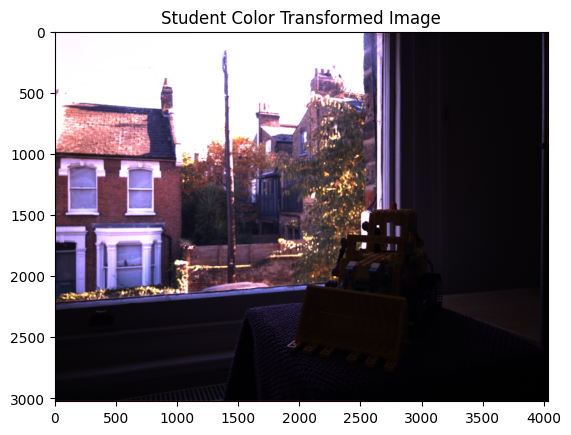

In [ ]:
rgb_img = student_color_transform(white_balanced_img)
plt.imshow(rgb_img)
plt.title("Student Color Transformed Image")
plt.show()

The last step is gamma encoding. The expected output:

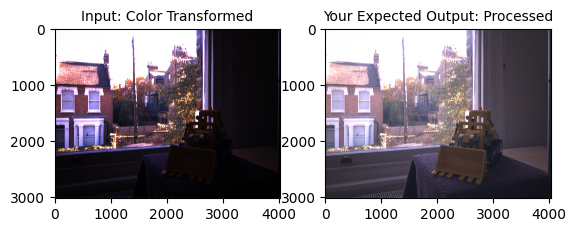

In [ ]:
def student_gamma_encode(color_transformed_image):
    """Gamma encodes an image.

    Args:
        color_transformed_image: [H,W,3] numpy array containing RGB values

    Returns:

        gamma_encoded_img: [H,W,3] numpy array

    Potential Implementation:

    [Lecture 2] For this section, you will need a value for the power. As discussed
    in class, a good value is lambda = 1 / 2.2. Try experimenting with different values.
    Our code will sanity check with the suggested lambda.
    """
    gamme_map = np.power(color_transformed_image, float(1.0/2.2))
    processed_image = np.nan_to_num(gamme_map)
    processed_image = np.clip(processed_image, 0, 1)

    return processed_image

In [ ]:
check_code_correctness(student_gamma_encode, rgb_img, np.load('/content/sol/processed.npy'))

<ipython-input-16-7e04c920f0bb>:17: RuntimeWarning: invalid value encountered in power
  gamme_map = np.power(color_transformed_image, float(1.0/2.2))


True

<ipython-input-16-7e04c920f0bb>:17: RuntimeWarning: invalid value encountered in power
  gamme_map = np.power(color_transformed_image, float(1.0/2.2))


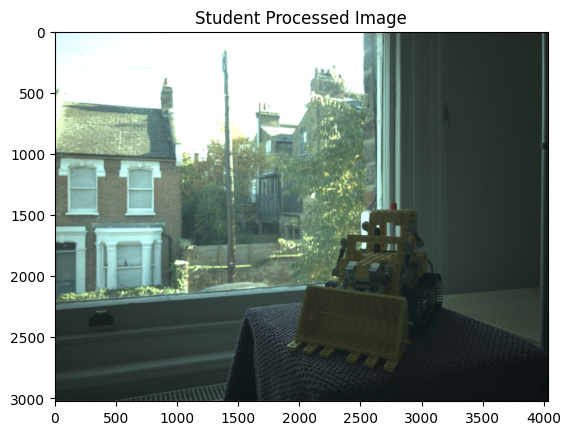

In [ ]:
processed_image = student_gamma_encode(white_balanced_img)
plt.imshow(processed_image)
plt.title("Student Processed Image")
plt.show()

If you tried any new techniques, briefly explain them here:

## Problem 2: Denoising

In class, we discussed how the imaging pipeline is not perfect: there are multiple sources of noise including Dark Current, ADC noise, and read noise. In this problem, we will follow the steps in Lecture 3 to estimate these various types of noise. We'll start by estimating the dark current then estimate gain and the ADC noise.

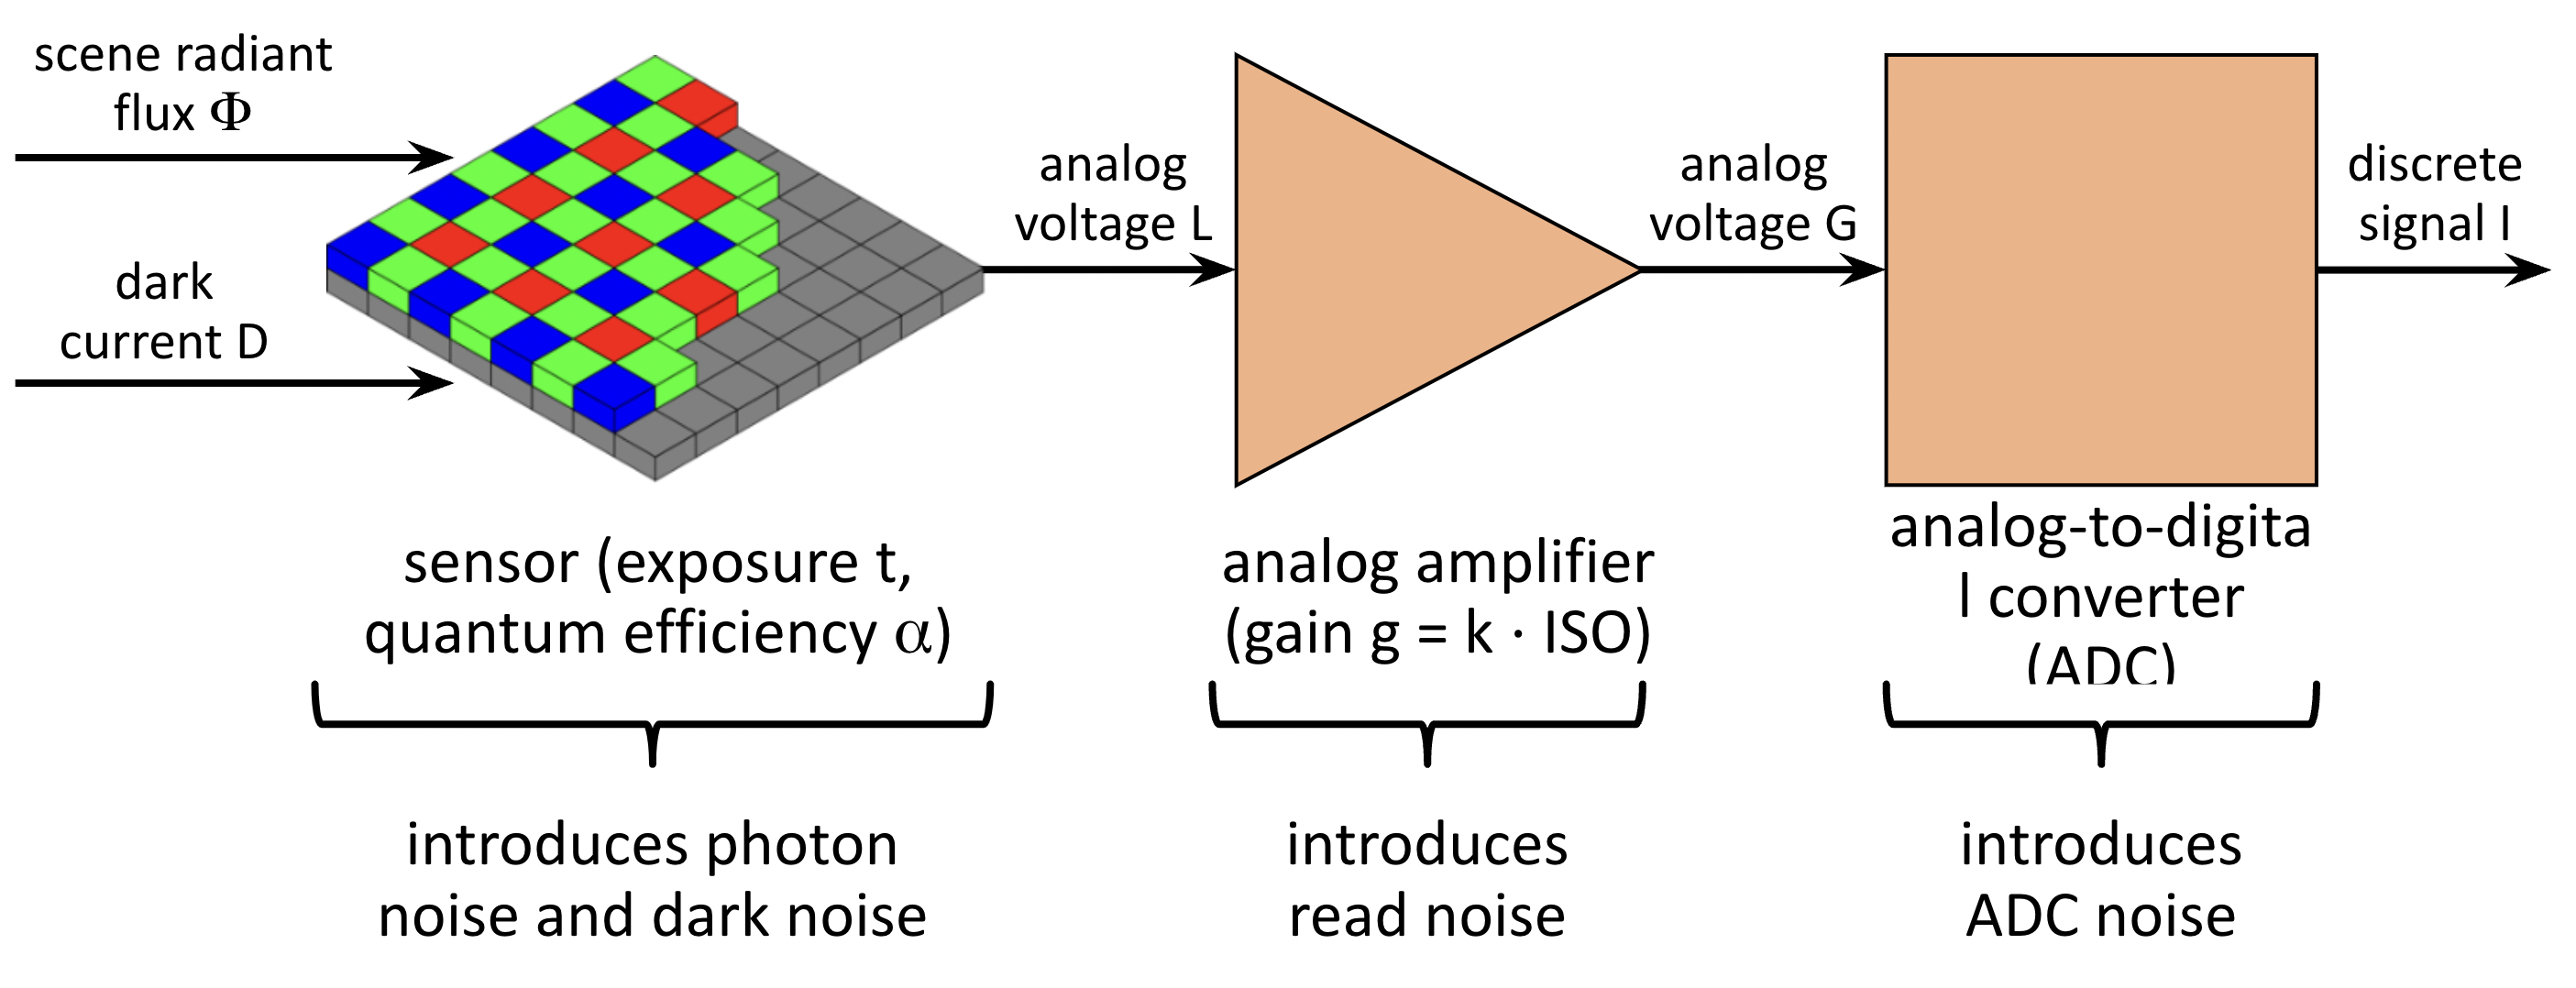

We'll set the parameters of the noise ourselves and then try to estimate them and see how close we get. Let's start by setting up some helper functions:

The input of this section is parameters for various types of noise and our expected outputs are to estimate these parameters with high accuracy.

linear fit to sig_add

In [ ]:
# Set parameters:
qe = 1 # Quantam efficiency
D = 0.05 # Dark Current
sigma_read = 0.03 # Std Dev. of read noise
sigma_adc = 0.03 # Std Dev of ADC noise
g = 1 # Gain


In [ ]:
def N_photon_detections(t, qe, flux):
    return np.random.poisson(t * qe * flux)

def N_phantom_detections(t, D):
    return np.random.poisson(t * D)

# Total number of detections
# t - exposure time, D - dark current
def N_detections(t, qe, flux, D):
    # ** STUDENT CODE HERE ** #multiple ways to do this
    return np.random.poisson(t * (qe * flux+D))


def n_read(sigma_read):
    return np.random.normal(scale=sigma_read)

def n_adc(sigma_adc):
    return np.random.normal(scale=sigma_adc)

To estimate scene flux, we can load a grayscale image and then use the values as flux. Flux should be a \[H,W\] array. Try implementing an image with 0 flux, or various levels of gray flux. We'll need them in the estimation process.

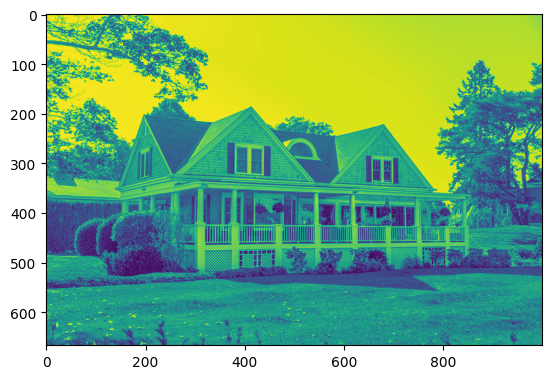

In [ ]:
img_path = "/content/sol/house_img.jpeg"
gray_img = np.array(Image.open(img_path).convert("L"))
plt.imshow(gray_img)

In [ ]:
# Returns flux from input image
def image_flux(img_path):
    gray_img = np.array(Image.open(img_path).convert("L"))
    flux = (255 - gray_img) / 255
    return flux

# Returns image with 0 flux everywhere
def zero_flux(size):
    # ** STUDENT CODE HERE **
    flux = np.zeros([size[0], size[1]])
    return flux


# Returns image with gray_level flux everywhere
def gray_level_flux(size, gray_level):
    # ** STUDENT CODE HERE **
    N = gray_level.shape[0]
    gray_level = np.broadcast_to(gray_level.reshape([N,1,1]), [N, size[0], size[1]])
    flux = np.multiply(np.ones([size[0], size[1]]), gray_level)
    return flux

Now, lets implement functions to calculate image values and statistics. We've implemented another function as well named "set_vals". It takes in values for D, quantam e efficiency, sigma read, and sigma adc and set the global values for these variables. Any values that are not explicitly set are kept the same. You will need to call this function later.

In [ ]:
def set_vals(D_val=None, sigma_read_val=None, sigma_adc_val=None, qe_val=None, g_val=None):
    if D_val is not None:
        global D
        D = D_val
    if qe_val is not None:
        global qe
        qe = qe_val
    if sigma_read_val is not None:
        global sigma_read
        sigma_read = sigma_read_val
    if sigma_adc_val is not None:
        global sigma_adc
        sigma_adc = sigma_adc_val
    if g_val is not None:
        global g
        g = g_val

# Get an image reading given the exposure and flux of the scene
def student_get_I(t, flux):
    # ** STUDENT CODE HERE **
    L = np.random.poisson(t*(qe*flux+D))
    I = L*g + n_read(sigma_read)*g + n_adc(sigma_adc)
    return I

# Estimate mean of image reading given exposure and flux
def student_get_E_I(t, flux):
    # ** STUDENT CODE HERE **
    E_I = t*(qe*flux+D)*g    # Lec5 Equation
    """
    L = np.random.poisson(t*(qe*flux+D))
    I = L*g + n_read(sigma_read)*g + n_adc(sigma_adc)
    E_I = np.mean(I)    # stats approach
    """
    return E_I

# Estimate variance of image reading given exposure and flux
def student_get_var_I(t, flux):
    # ** STUDENT CODE HERE **
    Var_I = t*(qe*flux+D)*(g**2) + (sigma_read**2)*(g**2) + (sigma_adc**2)  # Lec5 Equation
    """
    L = np.random.poisson(t*(qe*flux+D))
    I = L*g + n_read(sigma_read)*g + n_adc(sigma_adc)
    Var_I = np.var(I)
    """
    return Var_I

Lets see how our images "I" look:

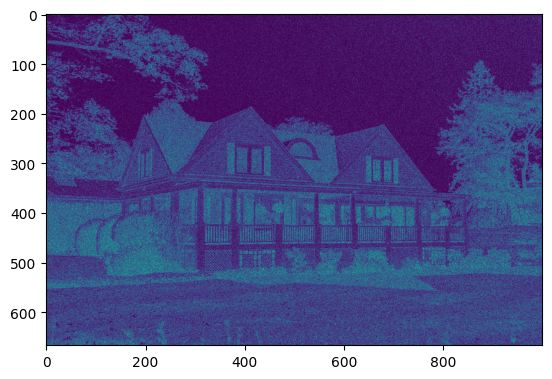

In [ ]:
I_hat = student_get_I(10, image_flux('/content/sol/house_img.jpeg')) # Try playing with the time to see how it looks
plt.imshow(I_hat)
plt.show()

Now that we have these helper functions, lets start by estimating dark current. We ideally want to get multiple samples that we can average. The N variable denotes how many samples we should average to get our final number.

In [ ]:
def student_estimate_dark_current(size, N=10, t=10000):
    """
    Estimates a value for D.
    """
    no_photon = zero_flux(size)
    dark_current_mat = np.zeros([N, size[0], size[1]])
    for i in range(N):
        set_vals(g_val=np.random.randint(1,100))
        t = np.random.randint(0.00001,10000)
        E_I = student_get_E_I(t, no_photon)
        dark_current_mat[i, :, :] = np.divide(E_I, t*g)
    return np.round(np.mean(dark_current_mat, axis=0), 2)

Let's test this out. Remember the expected value is 0.05.

In [ ]:
correct = True
for D_val in [0.01,0.02,0.05,0.06]:
    set_vals(D_val=D_val)
    est_D = student_estimate_dark_current((256,256))
    correct = correct and np.allclose([est_D], [D_val])
if correct:
    print("All tests passed")
else:
    print("Error!")

All tests passed


Now lets estimate n_read and n_adc. As we discussed in Lecture 5, we can do this through a multi-step process:
1. Compute mean and variance for various gray levels (the number of levels is set by N_levels)
2. Fit a line to the data and use it to estimate g and n_add
3. Use the estimated values of g and n_add to estimate n_read and n_adc.

How do we do step 3? We can leverage the following relationship:

$$n_{add} = \mathcal{N}(0, \sqrt{\sigma_{read}^2 \cdot g^2 + \sigma_{adc}^2})$$

In [ ]:
def student_estimate_read_adc(size, N_levels=5, N=10):
    """
    Estimates n_read and n_adc.

    Potential Implementation based on Lecture 5:
    1. Compute mean and variance for various gray levels (with dark current correction)
    2. Fit a line to the data and estimate parameters

    Returns:
        n_read: estimated n_read
        n_adc: estimated n_adc
    """
    # ** STUDENT CODE HERE **
    gray_level = np.linspace(0, 1, N_levels)
    gray_level_mats = gray_level_flux(size, gray_level)
    E_I_minusdark = np.zeros([N, N_levels, size[0], size[1]])
    VAR_I_minusdark = np.zeros([N, N_levels, size[0], size[1]])
    est_D = student_estimate_dark_current((256,256), N)

    for i in range(N):
        t = np.random.randint(0.00001, 10000)
        g_1 = 10
        set_vals(g_val=g_1)
        E_I_minusdark[i, :, :, :] = student_get_E_I(t, gray_level_mats)-est_D*t*g
        VAR_I_minusdark[i, :, :, :] = student_get_var_I(t, gray_level_mats)-est_D*t*(g**2)

    E_I_avg = np.mean(E_I_minusdark, axis=0)
    VAR_I_avg = np.mean(VAR_I_minusdark, axis=0)
    E_I_arr = E_I_avg[:, 0, 0]
    VAR_I_arr = VAR_I_avg[:, 0, 0]

    g_est_1, var_add_est_1 = np.polyfit(E_I_arr, VAR_I_arr, 1)

    for i in range(N):
        t = np.random.randint(0.00001, 10000)
        g_2 = 100
        set_vals(g_val=g_2)
        E_I_minusdark[i, :, :, :] = student_get_E_I(t, gray_level_mats)-est_D*t*g
        VAR_I_minusdark[i, :, :, :] = student_get_var_I(t, gray_level_mats)-est_D*t*(g**2)

    E_I_avg = np.mean(E_I_minusdark, axis=0)
    VAR_I_avg = np.mean(VAR_I_minusdark, axis=0)
    E_I_arr = E_I_avg[:, 0, 0]
    VAR_I_arr = VAR_I_avg[:, 0, 0]
    g_est_2, var_add_est_2 = np.polyfit(E_I_arr, VAR_I_arr, 1)

    # var_add_1 = var_read*(g_1**2)+var_adc
    # var_add_2 = var_read*(g_2**2)+var_adc
    sig_read = np.sqrt((var_add_est_2 - var_add_est_1)/((g_2**2)-(g_1**2)))
    sig_adc = np.sqrt(var_add_est_2 - (sig_read**2)*(g_2**2))
    return round(sig_read, 2), round(sig_adc, 2)

In [ ]:
student_estimate_read_adc((256,256))

(0.03, 0.03)

In [ ]:
correct = True
set_vals(D_val=0) # We've estimated it now and can subtract from input images
for n_adc, n_read in zip([0.01,0.02,0.05,0.06], [0.01, 0.05, 0.02, 0.01]):
    set_vals(sigma_adc_val=n_adc, sigma_read_val=n_read)
    est_n_read, est_n_adc = student_estimate_read_adc((256,256))
    correct = correct and np.allclose([est_n_read, est_n_adc], [n_read, n_adc])
if correct:
    print("All tests passed")
else:
    print("Error!")

All tests passed


If all tests are passing, congrats! You implemented a system to estimate the various noises in the imaging pipeline.

## Problem 3: HDR Imaging

In this problem, we will implement exposure bracketing for HDR reconstruction. We have access to a set of images taken at various exposure levels and we want to output a single HDR picture that better represents the scene.


Let's start by visualizing the expected output and input:

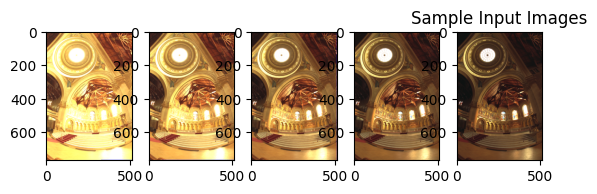

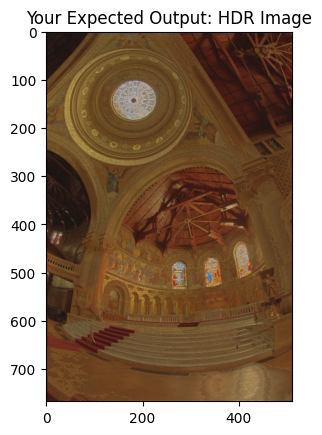

Lets load images in and reading exposure levels. We've written a function below that loads in the shutter speed, f-stop, and gain of the images.

In [ ]:
data_file = "/content/hdr/memorial.hdr_image_list.txt"
num_imgs = 0
ldr_imgs = []

with open(data_file, "r") as img_list:
    for line in img_list:
        if line[0] == "#":
            continue
        vals = line.split()
        if len(vals) == 1:
            num_imgs = int(vals[0])
        else:
            fname, inv_shutter_speed, f_stop, gain, nd_filters = vals
            inv_shutter_speed = float(inv_shutter_speed)
            f_stop = int(f_stop)
            gain = int(gain)
            I = np.array(Image.open('/content/hdr/'+fname.replace('.ppm', '.png')))
            ldr_imgs.append((I, inv_shutter_speed, f_stop, gain)) # Which one of these measures exposure time?

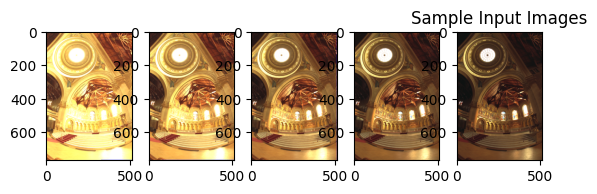

In [ ]:
# Visualize the first 5 images
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(ldr_imgs[i][0])
plt.title("Sample Input Images")
plt.show()

Now that we have the images, lets put them together following the exposure bracketing technique discussed in class. In this technique, we take pixel values from images with varying exposure, weight them by both pixel values and exposure values (see Lecture 5 for details) and then combine them to get an HDR image.

A key question you will have to answer is how to convert the data we have into exposure values we can use for weighting. As a hint, exposure values are generally integer numbers with 0 being the "middle".

In [ ]:
def student_hdr_reconstruct(imgs):
    """
    Recovers a HDR image from multiple LDR images.

    Args:
        imgs: a list of tuples containing: LDR image ([H,W,3]), 1/shutter speed, f-stop, gain

    Returns:
        hdr_img: a [H,W,3] HDR image
    """

    # shutter speed: log2 for the shutter
    # 0.95 0.05 clip
    # ** STUDENT CODE HERE **
    norm_ldr_mat = np.zeros([len(imgs), imgs[0][0].shape[0], imgs[0][0].shape[1], imgs[0][0].shape[2]])
    weight_mat = np.ones([len(imgs), imgs[0][0].shape[0], imgs[0][0].shape[1], imgs[0][0].shape[2]])

    for i in range(len(imgs)):
        ldr_imgs_checker = imgs[i][0]
        outlier= np.argwhere((((ldr_imgs_checker/255)<=0.05) | ((ldr_imgs_checker/255)>=0.95)))
        zero_index = np.unique(outlier[:,0:2], axis=0)
        inv_shutter_speed = imgs[i][1]
        exposure_t = abs(np.log2(inv_shutter_speed))+1

        for index in zero_index:
            ldr_imgs_checker[index[0], index[1]] = np.array([0, 0, 0])
            weight_mat[i, index[0], index[1], :] = np.array([0, 0, 0])

        weight_mat[i] = np.multiply(ldr_imgs_checker, (1/exposure_t)*weight_mat[i])
        norm_ldr_mat[i] = np.multiply(ldr_imgs_checker, np.divide(ldr_imgs_checker, exposure_t))

    weight_rgb = np.sum(weight_mat, axis=0)
    my_hdr = np.divide(np.sum(norm_ldr_mat, axis=0), weight_rgb)/255
    return my_hdr



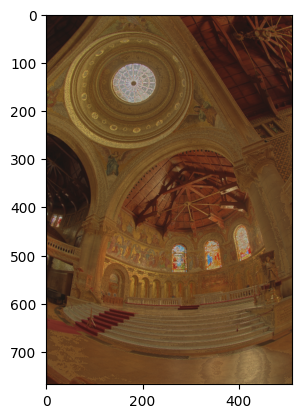

In [ ]:
plt.imshow(student_hdr_reconstruct(ldr_imgs))

In [ ]:
check_code_correctness(student_hdr_reconstruct, ldr_imgs, np.load('/content/sol/hdr.npy'))

True

If you used techniques not discussed in class, please briefly summarize them here:

## References

Many of the materials used here were compiled from various different academic papers and datasets:

Raw Dataset:

*NeRF in the Dark: High Dynamic Range View Synthesis from Noisy Raw Images*, Ben Mildenhall and Peter Hedman and Ricardo Martin-Brualla and Pratul P. Srinivasan and Jonathan T. Barron, CVPR (2022)

HDR dataset:

*Recovering High Dynamic Range Radiance Maps from Photographs.*, Paul E. Debevec and Jitendra Malik, SIGGRAPH 97, August 1997

Further Reading:

Chapter 2, *Computational Imaging*, Ayush Bhandari, Achuta Kadambi, and Ramesh Raskar, MIT Press, 2022.